In [2]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.measurement_models import transmission_rpi, capture_yield_rpi

from copy import copy

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs


In [8]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

In [3]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [4]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)

# energy_range_all = [150, 6000]
energy_range_all = [202, 227]

In [5]:
### 1mm capture data
capdat1 = sammy_functions.readlst(os.path.realpath("./data/yield_ta1b_unsmooth.dat"))
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                energy_grid = capdat1.E.values, #np.sort(capdat1.E.values),
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )

capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]

### 2mm capture data
capdat2 = sammy_functions.readlst(os.path.realpath("./data/yield_ta2_unsmooth.dat"))
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                energy_grid = np.sort(capdat2.E.values),
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]

### 1mm Transmission data
transdat1 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-1mm.twenty"))
transdat1_covfile = os.path.realpath('./data/trans-Ta-1mm.idc')

chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)

exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,
                                energy_grid = np.sort(transdat1.E.values),
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-3mm.twenty"))
transdat3_covfile = os.path.realpath("./data/trans-Ta-3mm.idc")

exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,
                                energy_grid = np.sort(transdat3.E.values),
                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-6mm.twenty"))
transdat6_covfile = os.path.realpath("./data/trans-Ta-6mm.idc")

exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,
                                energy_grid = np.sort(transdat6.E.values),
                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]

### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [2]:
### plotting function
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i][model_key], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:

        ax.set_xscale('log')
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig


# little bit modified

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[], f_model_name='fit',
    priors=[], priors_chi2=[], pr_model_name='prior',
    true=[], true_chi2=[], t_model_name ='true',
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (12,9)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=f'{colors[i]}', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'{f_model_name} {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'{f_model_name} {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'{pr_model_name} {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'{pr_model_name} {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'{t_model_name} {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'{t_model_name} {exp.title}'
                
            axes[iax].plot(true[i].E, true[i][model_key], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{'+f'{t_model_name}'+'}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{'+f'{pr_model_name}'+'}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{'+f'{f_model_name}'+'}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

NameError: name 'pd' is not defined

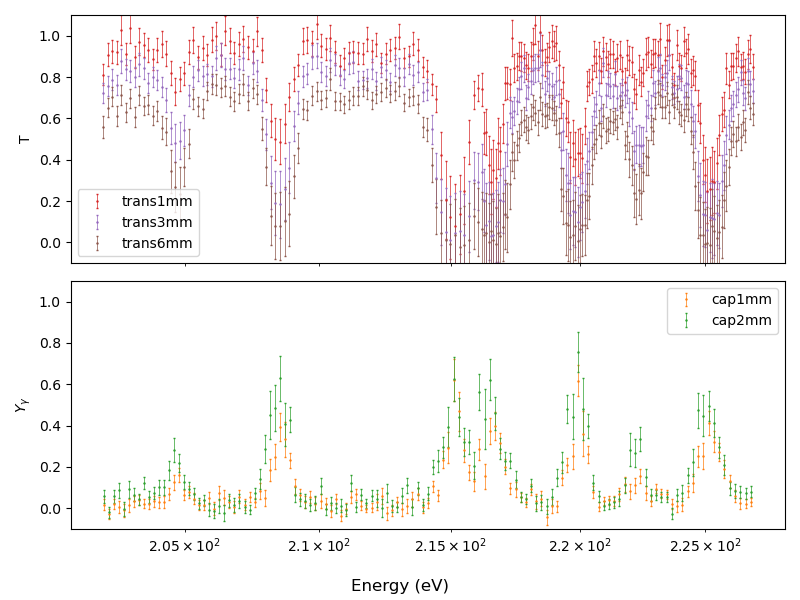

In [7]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]

covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []

for data, exp in zip(datasets, experiments):
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited')
    exp.template = os.path.realpath(filepath)


fig = plot(datasets, experiments)
fig.tight_layout()

In [8]:
## Could also plot covariance here



## Fit from ENDF or JEFF

In [10]:
sammyRTO = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : False
                              })

matnum = 7328

jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_all)+5) & (jeff_parameters.E>min(energy_range_all)-5)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))

jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0
55,230.62,64.9999,22.4200,1.0,1.0,1.0,2.0


In [11]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=0.881271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=1,
                        energy_range = energy_range_all)       # highest order l-wave to consider

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)


rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              # "sammy_runDIR": os.path.realpath("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/ATARI_workspace/sammyrunDIR")
                              "sammy_runDIR": os.path.realpath("/home/fire/py_projects/ATARI_YW_newstruct/ATARI/examples/Ta181_Analysis/sammy_rundir_py_gen")
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance=covariance_data,  #[{}, {}, {}, {}, {}], # 
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.05
    )



In [12]:
Ta_pair.spin_groups#['3.0']

{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 9.003,
  '<gn2>': 452.56615,
  'n_dof': 1,
  '<gg2>': 32.0,
  'g_dof': 1000,
  'quantiles': {'D01': 1.0184333135415622,
   'D99': 21.80043460630884,
   'gn01': 0.0710926470659408,
   'gn99': 3002.729610372257,
   'gg01': 28.765198301747624,
   'gg99': 35.42300781927096,
   'gt01': 28.836290948813566,
   'gt99': 3038.152618191528},
  'chs': 1,
  'Ls': [0]},
 4.0: {'Jpi': 4.0,
  'J_ID': 2,
  '<D>': 8.3031,
  '<gn2>': 332.24347,
  'n_dof': 1,
  '<gg2>': 32.0,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9392595407827331,
   'D99': 20.10565240249283,
   'gn01': 0.052191415006786285,
   'gn99': 2204.401069814494,
   'gg01': 28.765198301747624,
   'gg99': 35.42300781927096,
   'gt01': 28.81738971675441,
   'gt99': 2239.824077633765},
  'chs': 1,
  'Ls': [0]}}

In [13]:
# sammyOUT_JEFF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [14]:
# sammyINPyw.resonance_ladder = endf_parameters
# sammyOUT_ENDF = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [15]:
# sammyINPyw.resonance_ladder = endf8_parameters
# sammyOUT_ENDF8 = sammy_functions.run_sammy_YW(sammyINPyw, rto)

## Now Generate Syndat

In [17]:
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT


trans1mm_gen_meas = Transmission_RPI()
trans1mm_red_meas = Transmission_RPI()

trans3mm_gen_meas = Transmission_RPI()
trans3mm_red_meas = Transmission_RPI()

trans6mm_gen_meas = Transmission_RPI()
trans6mm_red_meas = Transmission_RPI()

cap1mm_gen_meas = Capture_Yield_RPI()
cap1mm_red_meas = Capture_Yield_RPI()

cap2mm_gen_meas = Capture_Yield_RPI()
cap2mm_red_meas = Capture_Yield_RPI()


In [18]:
synOPT = syndatOPT(calculate_covariance=True)
synOPT 

calculate_covariance: True
explicit_covariance: False
sampleRES: True
sampleTNCS: True
sampleTURP: True
sample_counting_noise: True
save_raw_data: False
smoothTNCS: False

In [19]:
synOPT.calculate_covariance = True
syndat_trans1mm = Syndat_Model(exptrans1,
                            trans1mm_gen_meas,
                            trans1mm_red_meas,
                            options = synOPT,
                            title='trans1mm')
syndat_trans3mm = Syndat_Model(exptrans3,
                            trans3mm_gen_meas,
                            trans3mm_red_meas,
                            options = synOPT,
                            title='trans3mm')
syndat_trans6mm = Syndat_Model(exptrans6,
                            trans6mm_gen_meas,
                            trans6mm_red_meas,
                            options = synOPT,
                            title='trans6mm')


synOPT.calculate_covariance = False
syndat_cap1mm = Syndat_Model(expcap1,
                            cap1mm_gen_meas,
                            cap1mm_red_meas,
                            options = synOPT,
                            title='cap1mm')

syndat_cap2mm = Syndat_Model(expcap2,
                            cap2mm_gen_meas,
                            cap2mm_red_meas,
                            options = synOPT,
                            title='cap2mm')

In [20]:
len(syndat_trans1mm.reductive_measurement_model.model_parameters.open_neutron_spectrum.E)
len(exptrans1.energy_grid)

199

In [22]:
from ATARI.syndat.control import Syndat_Control


# TODO: where we should create & assign  template for each exp. model??


syndat_models= [syndat_trans1mm, syndat_trans3mm, syndat_trans6mm, syndat_cap1mm, syndat_cap2mm]

templates = []

for exp in experiments:
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited')
    exp.template = os.path.realpath(filepath)


syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models = syndat_models,
                        model_correlations = None,
                        options=synOPT
                        )

rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              # "sammy_runDIR": os.path.realpath("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/ATARI_workspace/sammyrunDIR")
                              "sammy_runDIR": os.path.realpath("./sammy_rundir_py_gen")
                              })

syndat.sample(rto, num_samples=1)

In [23]:
sample1 = syndat.get_sample(0)

In [24]:
lengths = []
for key, val in sample1.items():
    print(key)
    print(len(val.pw_reduced))

trans1mm
199
trans3mm
199
trans6mm
199
cap1mm
124
cap2mm
125


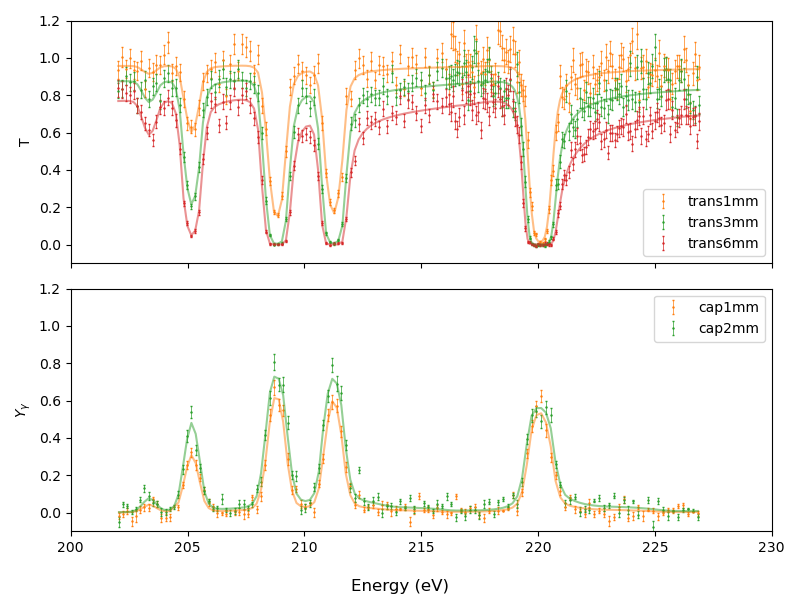

In [25]:
### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

colors = ["C1", "C2", "C3", "C4"]
### Trans
for it, key in enumerate(['trans1mm', 'trans3mm','trans6mm']):
    axes[0].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0,
                                            fmt='.',  color=colors[it], linewidth=0.5, markersize=1.5, capsize=1, label=key)

    axes[0].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[it], alpha=0.5)

axes[0].set_ylabel("T")

### Capture
for ic, key in enumerate(['cap1mm', 'cap2mm']):
    axes[1].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0, 
                                            fmt='.', color=colors[ic], linewidth=0.5, markersize=1.5, capsize=1, label=key)
    axes[1].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[ic], alpha=0.5)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,230])
    ax.set_ylim([-0.1,1.2])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [24]:
sample1.keys()

dict_keys(['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm'])

In [25]:
#sample1[list(sample1.keys())[0]].par_true
#sample1['cap1mm'].par_true
sample1['trans1mm'].par_true

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L
0,205.140028,59.865213,0.102874,1.0,29.932606,1.865271,3.0,0.0
1,222.214923,65.569058,220.912897,1.0,32.784529,3848.543903,3.0,0.0
2,225.727656,68.225403,21.719857,1.0,34.112701,375.427907,3.0,0.0
3,243.088596,58.141040,2.106751,1.0,29.070520,35.090773,3.0,0.0
4,202.708377,63.138866,14.010673,2.0,31.569433,255.555440,4.0,0.0
5,210.561203,59.539274,0.000668,2.0,29.769637,0.011959,4.0,0.0
6,228.128968,68.094749,2.277562,2.0,34.047374,39.159929,4.0,0.0
7,231.164331,62.101913,8.319094,2.0,31.050957,142.094607,4.0,0.0
8,239.165585,65.738481,3.304624,2.0,32.869240,55.492559,4.0,0.0
9,244.795904,63.926409,12.464219,2.0,31.963205,206.883078,4.0,0.0


In [26]:
start = copy(sample1['trans1mm'].par_true)
start["varyE"] = np.ones(len(start))
start["varyGg"] = np.ones(len(start))
start["varyGn1"] = np.ones(len(start))
start

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L,varyE,varyGg,varyGn1
0,205.178959,63.644838,6.567361,1.0,31.822419,119.065646,3.0,0.0,1.0,1.0,1.0
1,211.243248,65.363124,26.285397,1.0,32.681562,469.661654,3.0,0.0,1.0,1.0,1.0
2,216.998533,61.373962,0.010173,1.0,30.686981,0.179335,3.0,0.0,1.0,1.0,1.0
3,227.166255,62.560449,0.019840,1.0,31.280224,0.341850,3.0,0.0,1.0,1.0,1.0
4,238.135565,67.168586,0.393952,1.0,33.584293,6.629694,3.0,0.0,1.0,1.0,1.0
5,241.258394,65.779195,10.328582,1.0,32.889597,172.687720,3.0,0.0,1.0,1.0,1.0
6,249.479827,61.907314,25.092640,1.0,30.953657,412.563333,3.0,0.0,1.0,1.0,1.0
7,203.361052,71.510422,0.506178,2.0,35.755211,9.217879,4.0,0.0,1.0,1.0,1.0
8,208.509525,66.831275,0.451969,2.0,33.415637,8.128442,4.0,0.0,1.0,1.0,1.0
9,208.811627,67.864162,21.470899,2.0,33.932081,385.864539,4.0,0.0,1.0,1.0,1.0


In [27]:

datasets = [sample1['trans1mm'].pw_reduced, sample1['trans3mm'].pw_reduced, sample1['trans6mm'].pw_reduced, sample1['cap1mm'].pw_reduced, sample1['cap2mm'].pw_reduced]
experiments= [exptrans1, exptrans3, exptrans6, expcap1, expcap2]
covariance_data = [sample1['trans1mm'].covariance_data, sample1['trans3mm'].covariance_data, sample1['trans6mm'].covariance_data, {}, {}]


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance= covariance_data, 
    
    max_steps = 10,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.01
    )



In [28]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.01 : [445.742, 355.224, 378.384, 359.912, 484.276, 2023.538, 2.3919]
1    0.02 : [447.59, 354.308, 372.507, 359.038, 478.539, 2011.982, 2.3782]
2    0.04 : [448.052, 359.217, 369.838, 357.042, 475.703, 2009.852, 2.3757]
Chi2 improvement below threshold


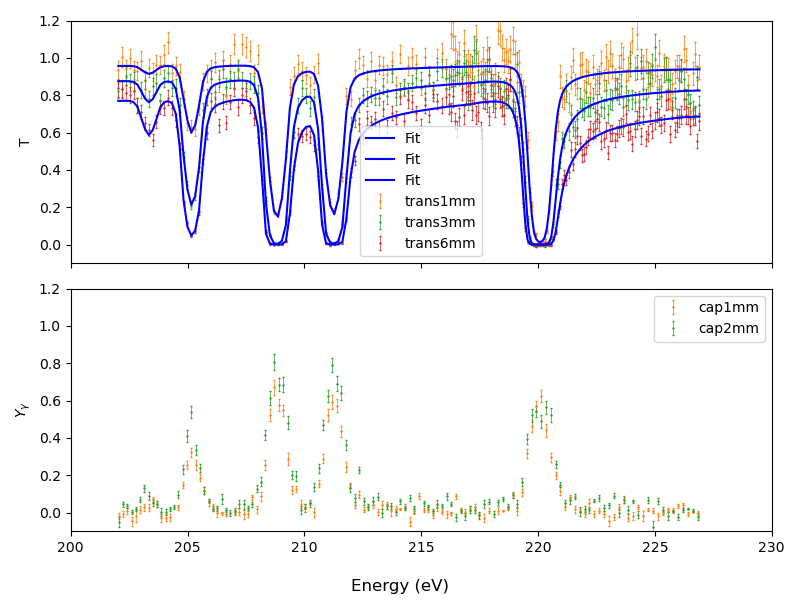

In [29]:
### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

colors = ["C1", "C2", "C3", "C4"]
### Trans
for it, key in enumerate(['trans1mm', 'trans3mm','trans6mm']):
    axes[0].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0,
                                            fmt='.',  color=colors[it], linewidth=0.5, markersize=1.5, capsize=1, label=key)
    # axes[0].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[it], alpha=0.5)

axes[0].set_ylabel("T")

### Capture
for ic, key in enumerate(['cap1mm', 'cap2mm']):
    axes[1].errorbar(sample1[key].pw_reduced.E, sample1[key].pw_reduced.exp, yerr=sample1[key].pw_reduced.exp_unc, zorder=0, 
                                            fmt='.', color=colors[ic], linewidth=0.5, markersize=1.5, capsize=1, label=key)
    # axes[1].plot(sample1[key].pw_reduced.E, sample1[key].pw_reduced.true, color=colors[ic], alpha=0.5)

axes[1].set_ylabel(r"$Y_{\gamma}$")

axes[0].plot(sammyOUT.pw_post[0].E, sammyOUT.pw_post[0].theo_trans, color='b', label='Fit')
axes[0].plot(sammyOUT.pw_post[1].E, sammyOUT.pw_post[1].theo_trans, color='b', label='Fit')
axes[0].plot(sammyOUT.pw_post[2].E, sammyOUT.pw_post[2].theo_trans, color='b', label='Fit')

### make it pretty
for ax in axes:
    ax.set_xlim([200,230])
    ax.set_ylim([-0.1,1.2])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()



In [30]:
sample1['trans1mm'].covariance_data['diag_stat']

,var_stat
E,
202.036981,0.001741
202.199565,0.002017
202.362345,0.001758
202.525321,0.001886
202.688494,0.001815
...,...
226.522995,0.001871
226.619477,0.003032
226.716020,0.003684


In [31]:
D = copy(sample1['trans1mm'].pw_reduced.exp)
T = copy(sammyOUT.pw_post[0].theo_trans)
# T = copy(sample1['trans1mm'].pw_reduced.true)

Cs = sample1['trans1mm'].covariance_data['Cov_sys']
Js = sample1['trans1mm'].covariance_data['Jac_sys']
stat = sample1['trans1mm'].covariance_data['diag_stat']

Cov = Js.T @ Cs @ Js + np.diag(stat['var_stat'])

(D-T) @ np.linalg.inv(Cov.values) @ (D-T).T

448.05247822653547

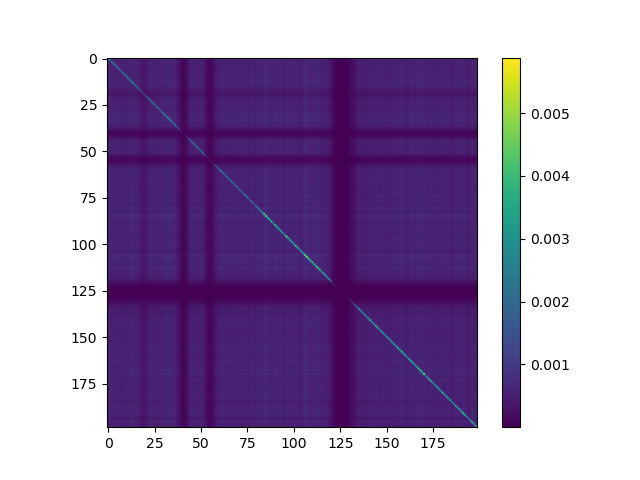

In [32]:
figure()
imshow(Cov)
colorbar()

In [36]:
sample1['trans1mm'].pw_reduced

,tof,E,true,exp,exp_unc
0,512680.366109,202.036981,0.853169,0.882844,0.022009
1,512475.545556,202.199565,0.755629,0.784706,0.019594
2,512270.725086,202.362345,0.592086,0.613078,0.015368
3,512065.904834,202.525321,0.445887,0.462434,0.011661
4,511861.084216,202.688494,0.371723,0.386184,0.009786
...,...,...,...,...,...
194,484363.938294,226.522995,0.805111,0.832791,0.020742
195,484261.528097,226.619477,0.826321,0.859605,0.021402
196,484159.117794,226.716020,0.839356,0.867437,0.021595
197,484056.707664,226.812625,0.847830,0.876994,0.021830


In [37]:
sammyOUT.pw_post[0]

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,202.036981,22.015329,4.404533,28.070611,0.0,0.882844,0.022009,0.853099,NaN
1,202.199565,42.835009,4.411636,49.509937,0.0,0.784706,0.019594,0.755613,NaN
2,202.362345,86.442245,4.428791,92.557736,0.0,0.613078,0.015368,0.592220,NaN
3,202.525321,136.263504,4.455225,142.595003,0.0,0.462434,0.011661,0.446156,NaN
4,202.688494,168.099177,4.477076,174.688963,0.0,0.386184,0.009786,0.372045,NaN
...,...,...,...,...,...,...,...,...,...
194,226.522995,32.327309,4.400461,38.375170,0.0,0.832791,0.020742,0.804766,NaN
195,226.619477,26.728321,4.398848,33.844920,0.0,0.859605,0.021402,0.825668,NaN
196,226.716020,25.125864,4.398442,31.138979,0.0,0.867437,0.021595,0.838411,NaN
197,226.812625,23.189952,4.397853,29.435338,0.0,0.876994,0.021830,0.846535,NaN
